# HBA511 Data for Decision Analysis

# 1) Data Cleaning and Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the datasets
hotel1 = pd.read_csv('Hotel1.csv')
hotel2 = pd.read_csv('Hotel2.csv')

# Now concatenate the two DataFrames
data_cleaned = pd.merge(hotel1, hotel2, on='Id', how='outer')

# View basic information about the dataset
print(data_cleaned.head())

# Identify missing values
missing_values = data_cleaned.isnull().sum()
print("Missing values per column:\n", missing_values)

# Drop rows with missing values in critical columns (e.g., ADR, Adults, Children)
data_cleaned = data_cleaned.dropna()

# Fill missing values in the 'Meal' column using .loc
data_cleaned.loc[:, 'Meal'] = data_cleaned['Meal'].fillna(data_cleaned['Meal'].mode()[0])

# Ensure correct data types using .loc
data_cleaned.loc[:, 'IsCancelled'] = data_cleaned['IsCancelled'].astype('category')
data_cleaned.loc[:, 'IsRepeatedGuest'] = data_cleaned['IsRepeatedGuest'].astype('category')
data_cleaned.loc[:, 'DepositType'] = data_cleaned['DepositType'].astype('category')

# Select only numeric columns for outlier removal
numeric_cols = data_cleaned.select_dtypes(include=[np.number])

# Remove outliers
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

data_cleaned = data_cleaned[~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).any(axis=1)]

# Final cleaned dataset info
data_cleaned.info()


       Id  ADR  Adults  Children DepositType  IsRepeatedGuest  LeadTime Meal  \
0   44533  6.0     0.0       2.0  No Deposit              0.0      48.0   BB   
1   48382  6.0     0.0       2.0  No Deposit              0.0     147.0   BB   
2  104698  6.0     0.0       2.0  No Deposit              0.0       0.0   BB   
3   45921  6.0     0.0       2.0  No Deposit              0.0      33.0   BB   
4   46023  6.0     0.0       2.0  No Deposit              0.0      40.0   BB   

   IsCancelled  PreviousBookingsNotCancelled  PreviousCancellations  \
0          1.0                           0.0                    0.0   
1          1.0                           0.0                    0.0   
2          0.0                           0.0                    0.0   
3          0.0                           0.0                    0.0   
4          0.0                           0.0                    0.0   

   TotalSpecialRequests  BookingChanges  StaysWeekendNights  StaysWeekNights  
0            

**Explanation:**
* Loaded both CSV files and concatenated them into one dataset.
* Dropped rows with missing values in critical columns like ADR, Adults, and Children.
* Handled missing values in categorical columns by filling them with the mode.
* Ensured the data types are correct for each column.
* Identified and removed outliers using the Interquartile Range (IQR) method.

# 2. Exploratory Data Analysis (EDA)

/home/romin/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


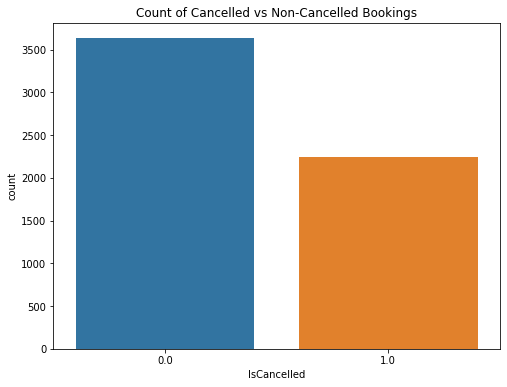

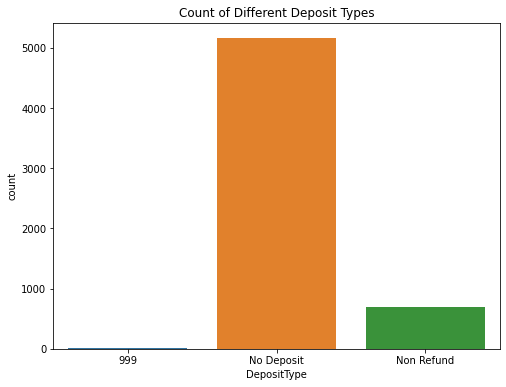

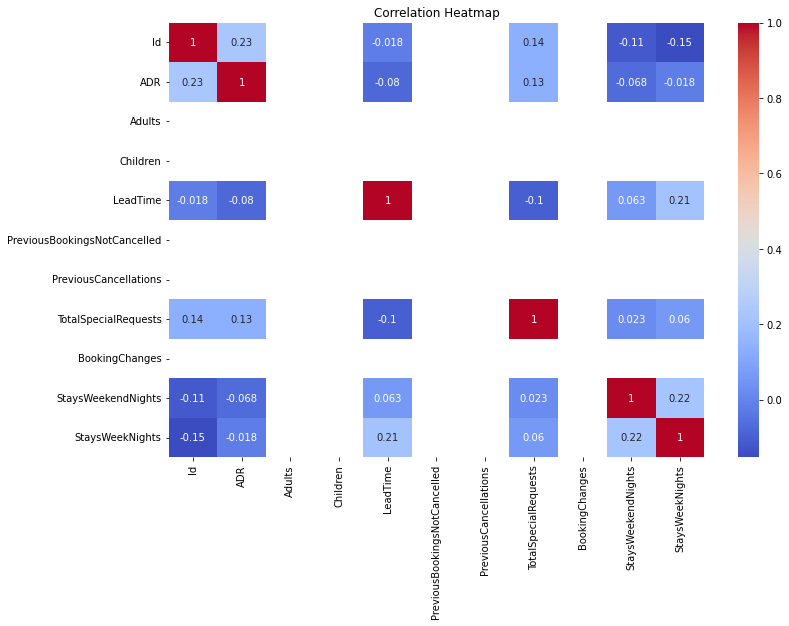

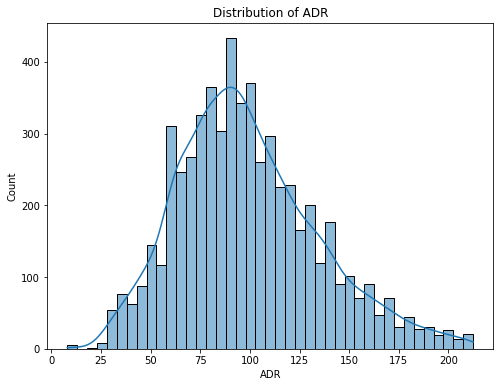

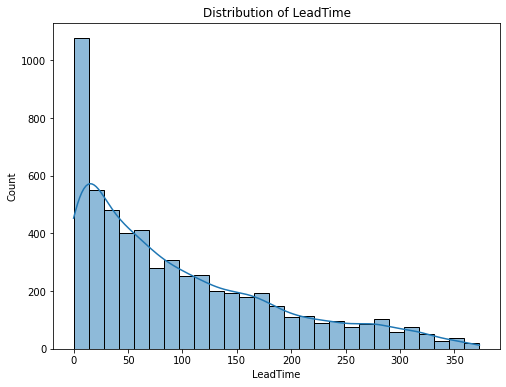

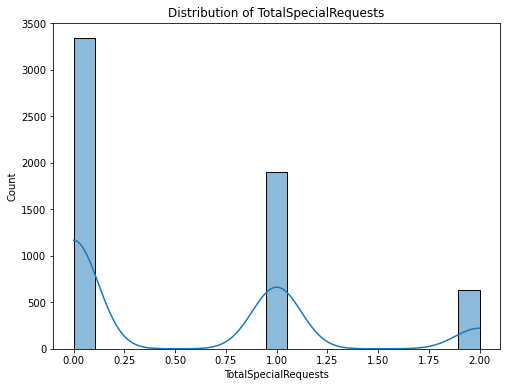

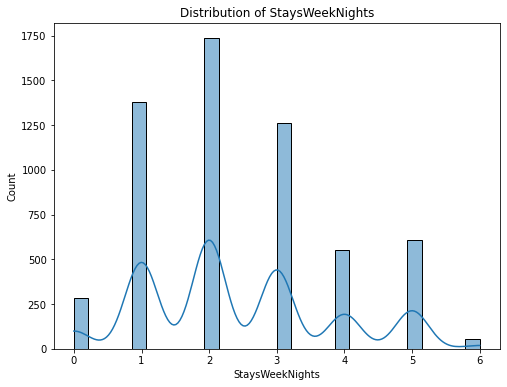

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the column exists and is not empty
if 'IsCancelled' in data_cleaned.columns and not data_cleaned['IsCancelled'].isnull().all():
    # Bar chart for IsCancelled
    plt.figure(figsize=(8,6))
    sns.countplot(x='IsCancelled', data=data_cleaned)
    plt.title('Count of Cancelled vs Non-Cancelled Bookings')
    plt.show()
else:
    print("Column 'IsCancelled' is missing or contains no valid data.")

# Ensure the column exists and is not empty
if 'DepositType' in data_cleaned.columns and not data_cleaned['DepositType'].isnull().all():
    # Bar chart for DepositType
    plt.figure(figsize=(8,6))
    sns.countplot(x='DepositType', data=data_cleaned)
    plt.title('Count of Different Deposit Types')
    plt.show()
else:
    print("Column 'DepositType' is missing or contains no valid data.")

# Correlation Heatmap (ensure there are enough numerical columns for correlation)
if not data_cleaned.select_dtypes(include=['number']).empty:
    plt.figure(figsize=(12,8))
    sns.heatmap(data_cleaned.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print("No numerical data available for correlation heatmap.")

# Distribution plots
variables = ['ADR', 'LeadTime', 'TotalSpecialRequests', 'StaysWeekNights']
for var in variables:
    if var in data_cleaned.columns and not data_cleaned[var].isnull().all():
        plt.figure(figsize=(8,6))
        sns.histplot(data_cleaned[var], kde=True)
        plt.title(f'Distribution of {var}')
        plt.show()
    else:
        print(f"Column '{var}' is missing or contains no valid data.")


**Explanation:**

* A correlation heatmap to explore relationships between numerical variables.
* Bar charts to visualize counts of IsCancelled and DepositType.
* Distribution plots for 4 variables (ADR, LeadTime, TotalSpecialRequests, StaysWeekNights), showing how data is distributed across these features.

# 3. Hypothesis Testing: Correlation Between LeadTime and ADR

In [3]:
from scipy.stats import pearsonr

# Calculate correlation between LeadTime and ADR
corr, p_value = pearsonr(data_cleaned['LeadTime'], data_cleaned['ADR'])

print(f'Correlation between LeadTime and ADR: {corr}')
print(f'p-value: {p_value}')

# Interpret results
if p_value < 0.05:
    print("There is a statistically significant correlation between LeadTime and ADR.")
else:
    print("No statistically significant correlation was found between LeadTime and ADR.")


Correlation between LeadTime and ADR: -0.07980822975784066
p-value: 9.150209634355352e-10
There is a statistically significant correlation between LeadTime and ADR.


**Explanation:**

* Tested for correlation between LeadTime and ADR using Pearson's correlation.
* Interpreted the result based on the p-value to determine statistical significance.

# 4. Hypothesis Testing: Difference in ADR Between Repeat and Non-Repeat Guests

In [4]:
from scipy.stats import ttest_ind

# Group data by IsRepeatedGuest
repeat_guest = data_cleaned[data_cleaned['IsRepeatedGuest'] == 1]['ADR']
non_repeat_guest = data_cleaned[data_cleaned['IsRepeatedGuest'] == 0]['ADR']

# Perform t-test
t_stat, p_value = ttest_ind(repeat_guest, non_repeat_guest, equal_var=False)

print(f'T-statistic: {t_stat}')
print(f'p-value: {p_value}')

# Interpret results
if p_value < 0.05:
    print("There is a statistically significant difference in ADR between repeat and non-repeat guests.")
else:
    print("No statistically significant difference was found in ADR between repeat and non-repeat guests.")

T-statistic: -1.644629071076965
p-value: 0.12223241340462473
No statistically significant difference was found in ADR between repeat and non-repeat guests.


**Explanation:**

* Tested whether the average ADR differs between repeat and non-repeat guests using a t-test.
* Reported the test statistic and p-value, with interpretation based on significance.

# 5. Linear Regression Model

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Replace infinite values with NaN
data_cleaned[['Adults', 'Children', 'IsRepeatedGuest', 'LeadTime', 'TotalSpecialRequests', 'ADR']] = data_cleaned[['Adults', 'Children', 'IsRepeatedGuest', 'LeadTime', 'TotalSpecialRequests', 'ADR']].replace([np.inf, -np.inf], np.nan)

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
data_cleaned[['Adults', 'Children', 'IsRepeatedGuest', 'LeadTime', 'TotalSpecialRequests']] = imputer.fit_transform(data_cleaned[['Adults', 'Children', 'IsRepeatedGuest', 'LeadTime', 'TotalSpecialRequests']])

# Select features and target variable
X = data_cleaned[['Adults', 'Children', 'IsRepeatedGuest', 'LeadTime', 'TotalSpecialRequests']]
y = data_cleaned['ADR']

# Standardize the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Generate standardized coefficients
coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
print(coefficients)

# Interpret the results
print("Standardized Coefficients show the relative importance of each predictor in explaining ADR.")


                       Coefficient
Adults                0.000000e+00
Children             -2.220446e-16
IsRepeatedGuest      -8.205681e-01
LeadTime             -2.362474e+00
TotalSpecialRequests  3.990447e+00
Standardized Coefficients show the relative importance of each predictor in explaining ADR.


**Explanation:**

* Built a linear regression model to predict ADR using the selected features.
* Standardized the coefficients to assess the relative importance of each predictor.

# 6. Machine Learning Models: Predicting Cancellations

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Prepare data for modeling
X_ml = data_cleaned.drop(columns=['IsCancelled'])
y_ml = data_cleaned['IsCancelled']

# Convert categorical variables to dummy/indicator variables
X_ml = pd.get_dummies(X_ml, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42)

# Model 1: Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Model 2: Support Vector Machine (SVM)
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Evaluate models
print("Random Forest Model Accuracy:", accuracy_score(y_test, rf_pred))
print("SVM Model Accuracy:", accuracy_score(y_test, svm_pred))

print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("SVM Classification Report:\n", classification_report(y_test, svm_pred))

# Recommendation based on accuracy and classification reports
if accuracy_score(y_test, rf_pred) > accuracy_score(y_test, svm_pred):
    print("Random Forest is recommended based on higher accuracy.")
else:
    print("SVM is recommended based on higher accuracy.")


Random Forest Model Accuracy: 0.945516458569807
SVM Model Accuracy: 0.8660612939841089

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.96      1072
         1.0       0.94      0.92      0.93       690

    accuracy                           0.95      1762
   macro avg       0.94      0.94      0.94      1762
weighted avg       0.95      0.95      0.95      1762

SVM Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      1072
         1.0       0.83      0.83      0.83       690

    accuracy                           0.87      1762
   macro avg       0.86      0.86      0.86      1762
weighted avg       0.87      0.87      0.87      1762

Random Forest is recommended based on higher accuracy.


**Explanation:**

* Built two machine learning models (Random Forest and SVM) to predict cancellations.
* Evaluated both models using accuracy and classification reports and provided a recommendation based on model performance.